In [1]:
from collections import defaultdict
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

In [ ]:
A = np.array([[0, 1, 0.5],
              [1, 0, 0.3],
              [0.5, 0.3, 0]])

In [ ]:
G = nx.from_numpy_array(A)

In [ ]:
pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=600)

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges,
                       width=6)

labels=nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, font_size=10, font_family='sans-serif', edge_labels=labels)
plt.axis('off')
plt.savefig("test.png", dpi=1000)

In [ ]:
nx.shortest_path(G, 0, 1, weight='weight')

In [ ]:
predecessors, distance = nx.floyd_warshall_predecessor_and_distance(G)

In [ ]:
nx.is_connected(G)

In [ ]:
nx.to_numpy_array(G)

In [ ]:
np.array(list(path))

In [ ]:
G = nx.Graph()

G.add_edge('a', 'b', weight=0.6)
G.add_edge('a', 'c', weight=0.2)
G.add_edge('c', 'd', weight=0.1)
G.add_edge('c', 'e', weight=0.7)
G.add_edge('c', 'f', weight=0.9)
G.add_edge('a', 'd', weight=0.3)


pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=600)

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges,
                       width=6)

# labels
names = {'a': '1, 1',
         'b': '2, 3',
         'c': '3, 4',
         'd': '23, 23'}

labels=nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif', labels=names)
nx.draw_networkx_edge_labels(G, pos, font_size=10, font_family='sans-serif', edge_labels=labels)
plt.axis('off')
plt.savefig("test.png", dpi=1000)

In [ ]:
A = np.random.randn(5, 3)

In [ ]:
A = np.random.randint(0, 100, size=(25, 25))

In [ ]:
from scipy.stats import entropy

In [ ]:
entropy([0, 0, 1], base=2)

In [ ]:
A[0, 0]

In [ ]:
A = torch.rand((5, 5)) - 0.5
A  = A / torch.norm(A, p=2, dim=1, keepdim=True)

In [ ]:
A[range(5), range(5)] = -2

In [ ]:
A

In [ ]:
max_idx = A.argmax(dim=1)
max_idx

In [ ]:
non_edges = A < 0.4
non_edges

In [ ]:
non_edges[range(5), max_idx] = False
non_edges

In [ ]:
A[non_edges] = np.nan

In [ ]:
print(A)
A = A.detach().cpu().numpy()

In [ ]:
np.isnan(A[0, 0])

In [ ]:
A[range(len(A) - 1)]

In [2]:
with open('../experiments/configs/no_landmark.json') as f:
    config = json.load(f)

In [3]:
mode = config['mode']
minigrid_config = config['env']
env_id=None
set_seed(config['seed'])

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)

using seed 333


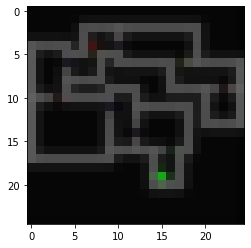

In [4]:
obs = env.reset()
plt.imshow(obs)
steps = int(5e3)

In [5]:
for i in range(steps):
    _, _, d, _ = env.step(env.action_space.sample())
    if d:
        print('{} steps done!'.format(i))
        env.reset()

499 steps done!
999 steps done!
1499 steps done!
1999 steps done!
2499 steps done!
2999 steps done!
3499 steps done!
3999 steps done!
4499 steps done!
4999 steps done!


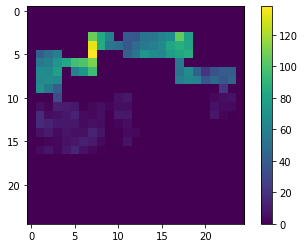

In [6]:
plt.imshow(env.visited.T)
plt.colorbar()

In [ ]:
mode = 'multiroom'
# minigrid_config = {'size': [25, 25], 'epsilon': 0.5}
minigrid_config = {'epsilon': 0.5}
env_id=None
set_seed(333)

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)
obs = env.reset()
# plt.imshow(obs[:, :, 0] - obs[:, :, 1])
# plt.colorbar()

In [ ]:
env.step(0)

In [ ]:
plt.imshow(obs)

In [ ]:
env.goal_pos

In [ ]:
plt.imshow(obs)

In [ ]:
plt.imshow(env.get_goal_state())

In [ ]:
plt.imshow(obs)

In [ ]:
pos = tuple(env.agent_pos)
pos

In [ ]:
idx = (obs[:, :, 0] - obs[:, :, 1]).argmax()

In [ ]:
agent_pos = idx // 25, idx % 25

In [ ]:
A = np.zeros((25, 25))

In [ ]:
A[agent_pos] = 1

In [ ]:
obs[agent_pos] = (1, 1, 1)
plt.imshow(obs)

### Successor Features Heatmap

In [ ]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for x in range(side_size):
        for y in range(side_size):
            grid[x, y] = np.linalg.norm(sr_matrix[x, y] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


In [ ]:
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200411-run0-100k.pt', (14, 4), -1, -1, True)
figure = plt.figure(figsize=(10, 10))
plt.imshow(dsr_heatmap.T)
plt.colorbar()

### Subgoal Q-Values

In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
config_file = '../data/local/20200411/multiroom/run_0/params.json'
with open(config_file, 'r') as f:
    config = json.load(f)

In [ ]:
mode = config['mode']
seed = config['seed']
set_seed(seed)

device = torch.device('cuda', index=0)

In [ ]:
checkpoint = '../data/local/20200411/multiroom/run_0/itr_99999.pkl'

In [ ]:
params = torch.load(checkpoint, map_location=device)

In [ ]:
ENV_ID = 'MiniGrid-FourRooms-v0'
env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
obs = env.reset()

In [ ]:
feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
feature_model.to(device)

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()
action_dsr = dsr.mean(axis=2)  # normalize direction dimension
normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

### Find Landmarks

In [ ]:
state_dsr = action_dsr.mean(axis=2)

In [ ]:
raw_s_features = state_dsr.reshape(25 * 25, 64)

In [ ]:
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [ ]:
indices = np.array(list(itertools.product(range(25), range(25))))

In [ ]:
kmedoids = KMedoids(n_clusters=8, random_state=seed).fit(s_features)
landmarks = kmedoids.medoid_indices_
landmark_states = indices[~walls][landmarks]
landmark_states

In [ ]:
landmark_map = walls.astype(int).reshape(25, 25)
landmark_map[landmark_states[:, 0], landmark_states[:, 1]] = 2

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(landmark_map.T)

### Subgoal Policy

In [ ]:
subgoal = (14, 4)

In [ ]:
env.unwrapped.agent_pos = np.array(subgoal)

obs, _, _, _ = env.env.env.step(5)
obs = torch.Tensor(obs).unsqueeze(0)
features = feature_model(obs.to(device), mode='encode')
features = features.squeeze().detach().cpu().numpy()
normed_features = features / np.linalg.norm(features, ord=2)



q_values = np.dot(normed_dsr, normed_features)

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')
        
        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='k')
            plt.gca().add_artist(circle)
        
        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
    
plt.colorbar()

### T-SNE Plots

In [ ]:
import itertools
from sklearn.manifold import TSNE

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()

In [ ]:
raw_sf = dsr.mean(axis=(2, 3))

In [ ]:
s_features = raw_sf.reshape(25 * 25, 64)
walls = np.isnan(s_features).any(axis=1)
s_features = s_features[~walls]

In [ ]:
sf_embedded = TSNE(n_components=2).fit_transform(s_features)

In [ ]:
rooms = np.zeros((25, 25))

In [ ]:
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i

In [ ]:
rooms = rooms.reshape(25 * 25)[~walls]

In [ ]:
figure = plt.figure(figsize=(10, 10))
data = sf_embedded[rooms == 0]
plt.scatter(data[:, 0], data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    data = sf_embedded[rooms == i]
    plt.scatter(data[:, 0], data[:, 1], label='Room ' + str(i))
plt.legend()